# Overview

## Imports and image loading

In [1]:
import math
import matplotlib
import matplotlib.pyplot as plt

from PIL import Image
import PIL.ImageOps
import numpy as np
from scipy import ndimage
from skimage.util import random_noise

In [2]:
cam = Image.open('cameraman.tif', mode='r').convert(mode="L")
lena = Image.open('lena.tiff', mode='r').convert(mode="L")

In [3]:
noisy_lena = random_noise(np.array(lena), mode='gaussian')

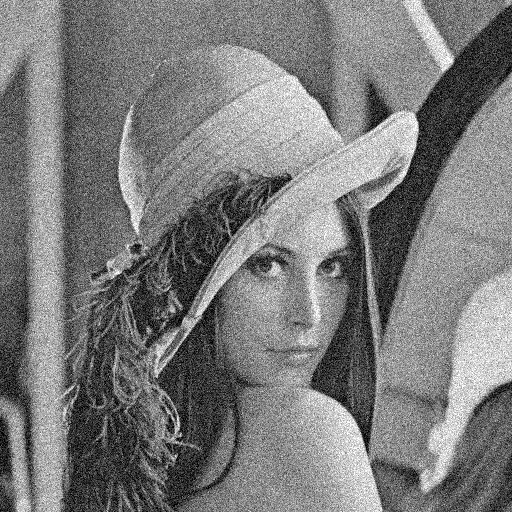

In [4]:
Image.fromarray(np.uint8(noisy_lena*255))